In [1]:
!kaggle competitions download -c cian-datafest-2019

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: the following arguments are required: command


In [ ]:
!unzip cian-datafest-2019.zip

In [ ]:
!mkdir cian-datafest-2019

In [ ]:
!mv cian_datafest.zip test.zip train.zip cian-datafest-2019

In [ ]:
!unzip -q cian-datafest-2019/train.zip -d cian-datafest-2019

In [3]:
!unzip -qo cian-datafest-2019/test.zip -d cian-datafest-2019

In [1]:
from glob import glob

train_images = glob ('cian-datafest-2019/train/*/*.jpg')

In [2]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (131072, 131072))

# Добавим локальности - довавим среднее по каналам в верхней части и в нижней

In [3]:
image = Image.open("cian-datafest-2019/train/outdoor/4688.jpg").convert(mode='RGB')
np_image = np.array(image)
print(np_image.shape)
half_height = image.height // 2
print(half_height)
upper = np_image[:, :half_height, c]
lower = np_image[:, half_height:, c]
upper.mean()
upper.shape

NameError: name 'Image' is not defined

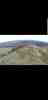

In [46]:
import matplotlib.pyplot as plt
image

In [4]:
from PIL import Image
import numpy as np

indoor=[]
outdoor=[]

def get_features(image):
    np_image = np.array(image) #преобразуем в массив
    half_height = np_image.shape[1] // 2

    
    features = []
    for c in range(3):
        upper = np_image[:half_height, :, c]
        lower = np_image[half_height:, :, c]
        upper_non_black = upper[upper > 0]
        lower_non_black = lower[lower > 0]
        if upper_non_black.size == 0 or lower_non_black.size == 0:
            return []
        features.extend([upper_non_black.mean(), lower_non_black.mean()])  # ignore black
    return features

for path in train_images:
    image = Image.open(path).convert(mode='RGB') #открываем картинку

    features = get_features(image)
    if len(features) == 0:
        continue
    
    image_class = path.split('/')[-2] #определяем класс

    if image_class == 'indoor':
        indoor.append(features)
    else:
        outdoor.append(features)

In [5]:
len(indoor), len(outdoor)

(27674, 26577)

In [6]:
X=indoor+outdoor
y=[0 for i in range(len(indoor))]+[1 for i in range(len(outdoor))]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [79]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [80]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)],
    voting='hard'
)

In [81]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(random_state=42))])

In [83]:
from sklearn.metrics import accuracy_score

In [85]:
y_pred = voting_clf.predict(X_test)

In [84]:
print(accuracy_score(y_test, y_pred))

0.8232691882326919


# Теперь без sklearn, но с gradient descend

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)

# add bias
X_train = np.concatenate((np.ones((len(X_train),1)),X_train),axis=1)

# normalize values
Xnorm = np.array(X_train).copy()
minx = np.min(X_train[:,1:])
maxx = np.max(X_train[:,1:])
Xnorm[:,1:] = (X_train[:,1:]-minx)/(maxx-minx)
Xnorm[:10,:]

array([[1.        , 0.49420096, 0.4058399 , 0.47798327, 0.40434383,
        0.4688757 , 0.37851706],
       [1.        , 0.69615084, 0.41565515, 0.51076802, 0.3236475 ,
        0.3702577 , 0.27075088],
       [1.        , 0.54271102, 0.35509291, 0.63919843, 0.38896693,
        0.77721417, 0.24813564],
       [1.        , 0.46984323, 0.56486137, 0.4427254 , 0.54593954,
        0.40184436, 0.53474228],
       [1.        , 0.47404582, 0.37338425, 0.50857287, 0.36447717,
        0.53926844, 0.30093088],
       [1.        , 0.51694104, 0.38381041, 0.50627996, 0.33081172,
        0.49539733, 0.3330146 ],
       [1.        , 0.58600038, 0.66708661, 0.60036614, 0.63056841,
        0.60964803, 0.60029774],
       [1.        , 0.68259772, 0.47839484, 0.7174264 , 0.51407907,
        0.68721998, 0.50988669],
       [1.        , 0.88762598, 0.83852028, 0.79782562, 0.78487627,
        0.7458191 , 0.7611492 ],
       [1.        , 0.46053148, 0.37462843, 0.56264173, 0.49548425,
        0.53819517, 0.3

In [10]:
ynorm = y_train.copy()
m = len(ynorm)

In [11]:
theta0 = np.zeros((X_train.shape[1],1))+0.4

In [ ]:
a = Xnorm.dot(theta0)-ynorm
print(a.shape, Xnorm.shape)


In [17]:
# calculate gradient
def grad(theta):
    dJ = 1/m*np.sum((Xnorm.dot(theta)-ynorm)*Xnorm,axis=0).reshape(-1,1)
    return dJ

In [ ]:
grad(theta0)

In [16]:
def cost(theta):
    J = np.sum((Xnorm.dot(theta)-ynorm)**2,axis=0)[0]
    return J

In [17]:
def GD(theta0,learning_rate = 0.5,epochs=1000,TOL=1e-7):
    
    theta_history = [theta0]
    J_history = [cost(theta0)]
    
    thetanew = theta0*10000
    print(f'epoch \t Cost(J) \t')
    for epoch in range(epochs):
        if epoch%100 == 0:
            print(f'{epoch:5d}\t{J_history[-1]:7.4f}\t')
        dJ = grad(theta0)
        J = cost(theta0)
        
        thetanew = theta0 - learning_rate*dJ
        theta_history.append(thetanew)
        J_history.append(J)
        
        if np.sum((thetanew - theta0)**2) < TOL:
            print('Convergence achieved.')
            break
        theta0 = thetanew

    return thetanew,theta_history,J_history